In [1]:
import xml.etree.ElementTree as ET
from os import listdir
import pandas as pd
import nltk
from regex import search
from gensim import corpora, models
from itertools import chain

C:\Users\Britt\AppData\Local\Continuum\Anaconda3\envs\text\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


## Grab and format the data

In [2]:
files = [ET.parse('../data/articles/{}'.format(a)) for a in listdir('../data/articles') if "_2016" in a]

In [3]:
print('Number of files retrieved: {:,}'.format(len(files)))

Number of files retrieved: 464


In [5]:
publications = []
titles = []
dates = []
text = []

for file in files:
    publications.append(file.find("publication").text)
    titles.append(file.find("title").text)
    dates.append(file.find("date_published").text)
    text.append(file.find("text").text)
    
df = pd.DataFrame({'publication': publications, 'text': text, 'date': dates, 'title': titles})

In [6]:
df.head()

,date,publication,text,title
0,2016-09-16T00:00:00Z,THE DAILY TELEGRAPH (LONDON),Importance of having a good scrum-half is best...,Why Fotuali'i has put Bath on cloud nine - AUS...
1,2016-09-16T00:00:00Z,THE GUARDIAN,Bringing characters back from the dead is a ti...,Neighbours' Madeleine West to return to Ramsay...
2,2016-09-16T00:00:00Z,THE DAILY TELEGRAPH (LONDON),Forty Autumns by Nina Willner\n\nA family's st...,bookshop
3,2016-09-16T00:00:00Z,THE GUARDIAN,Related: Party politics: why grime defines t...,"Youth in revolt: is 2016 a new dawn for young,..."
4,2016-09-16T00:00:00Z,THE GUARDIAN,They are avant-garde and often tricky to wear ...,Avant-garde Alexander Calder jewellery to go o...


In [7]:
def get_cleaned_tokens(sentence):
    """Returns a list of tokens with the tokens containing stopwords and tokens containing only punctuation or digits removed."""
    tokens = [a for a in nltk.word_tokenize(sentence) 
              if not search(r"^[\p{P}|\d]+$", a) and a not in nltk.corpus.stopwords.words( 'english' )]
    return tokens

def tokenize_text(text):
    """Returns a list of lists wherein each list entry represents a sentence in the form of tokens.
    
    All entries in the list are lowercased.
    """
    text = text.lower()
    word_tokens = [get_cleaned_tokens(sentence) for sentence in nltk.sent_tokenize(text)]
    return word_tokens

In [8]:
df['title_tokens'] = df['title'].map(tokenize_text)

In [9]:
df.head()

,date,publication,text,title,title_tokens
0,2016-09-16T00:00:00Z,THE DAILY TELEGRAPH (LONDON),Importance of having a good scrum-half is best...,Why Fotuali'i has put Bath on cloud nine - AUS...,"[[fotuali'i, put, bath, cloud, nine, austin, h..."
1,2016-09-16T00:00:00Z,THE GUARDIAN,Bringing characters back from the dead is a ti...,Neighbours' Madeleine West to return to Ramsay...,"[[neighbours, madeleine, west, return, ramsay,..."
2,2016-09-16T00:00:00Z,THE DAILY TELEGRAPH (LONDON),Forty Autumns by Nina Willner\n\nA family's st...,bookshop,[[bookshop]]
3,2016-09-16T00:00:00Z,THE GUARDIAN,Related: Party politics: why grime defines t...,"Youth in revolt: is 2016 a new dawn for young,...","[[youth, revolt, new, dawn, young, politicised..."
4,2016-09-16T00:00:00Z,THE GUARDIAN,They are avant-garde and often tricky to wear ...,Avant-garde Alexander Calder jewellery to go o...,"[[avant-garde, alexander, calder, jewellery, g..."


In [10]:
df.iloc[0]['title_tokens']

[["fotuali'i", 'put', 'bath', 'cloud', 'nine', 'austin', 'healey']]

## Do some modeling

In [11]:
dictionary = corpora.Dictionary(df['title_tokens'].map(chain.from_iterable))
corpus =  [dictionary.doc2bow(text) for text in df['title_tokens'].map(chain.from_iterable)]

In [12]:
print('Num words in dictionary: {:,}\nSome examples and counts: {}'.format(len(dictionary.token2id.items()), list(dictionary.token2id.items())[0:10]))

Num words in dictionary: 3,359
Some examples and counts: [('bbc', 313), ('christensen', 1613), ('data', 161), ('exit', 868), ('funding', 2195), ('mark', 2797), ('green', 1359), ('students', 3105), ('tackles', 51), ('syria', 429)]


In [13]:
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [14]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=2)
lsi.print_topics(2)

[(0,
  '-0.241*"trump" + -0.236*"love" + -0.200*"\'s" + -0.199*"us" + -0.147*"still" + -0.138*"clinton" + -0.135*"first" + -0.132*"team" + -0.130*"could" + -0.128*"hillary"'),
 (1,
  '0.350*"love" + 0.182*"hacking" + 0.182*"lauri" + 0.182*"appeal" + 0.182*"computer" + 0.182*"defence" + 0.182*"extradition" + 0.182*"99-year" + 0.182*"sentence" + 0.182*"syndrome"')]

## Now what if we try to find the number of topics in a more interesting way...

In [15]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
import numpy as np

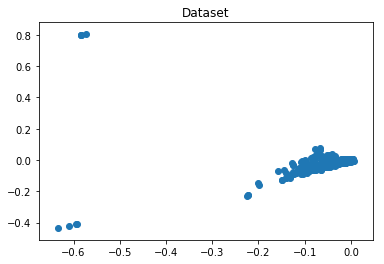

[[-0.01763877 -0.01715498]
 [-0.02365226 -0.01415679]
 [-0.00174845 -0.00205821]
 [-0.02320132 -0.00905449]
 [-0.03952444 -0.03423087]]


In [38]:
X = np.array([[a[1], b[1]] for a, b in lsi[corpus_tfidf]])

plt.title('Dataset')
plt.scatter([x for (x,y) in X], [y for (x,y) in X])
plt.show()

print(X[0:5])

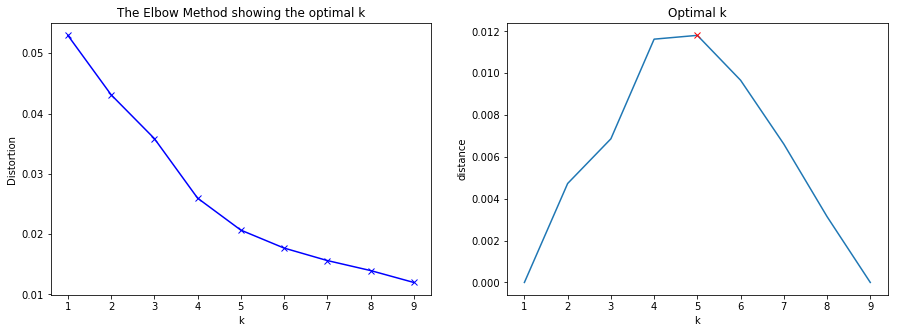

In [37]:
# k means determine k
distortions = []
models = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    models.append(kmeanModel)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
    

plt.figure(figsize=(15,5))
plt.subplot(121)
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')

new_points = [np.array(a) for a in zip(K, distortions)]
second_derivs = []
for index in range(0, len(new_points)):
    second_derivs.append(np.linalg.norm(np.cross(new_points[-1]-new_points[0], 
                                                 new_points[0]-new_points[index]))/np.linalg.norm(new_points[-1]-new_points[0]))
    
plt.subplot(122)
plt.plot(K, second_derivs)
plt.plot(second_derivs.index(max(second_derivs))+1, max(second_derivs), 'rx')
plt.xlabel('k')
plt.ylabel('distance')
plt.title('Optimal k')
plt.show()

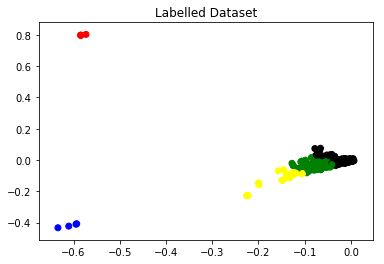

In [45]:
colors = ['black', 'red', 'blue', 'yellow', 'green', 'yellow']

plt.title('Labelled Dataset')
plt.scatter([x for (x,y) in X], [y for (x,y) in X], c=[colors[x] for x in models[4].labels_])
plt.show()

## So, what are the topics about?

In [47]:
from wordcloud import WordCloud

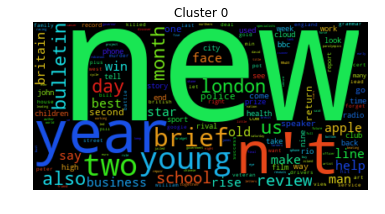

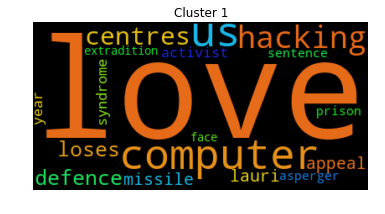

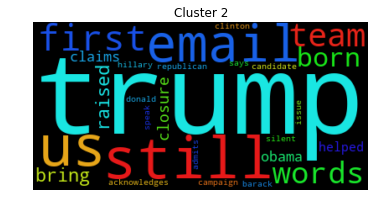

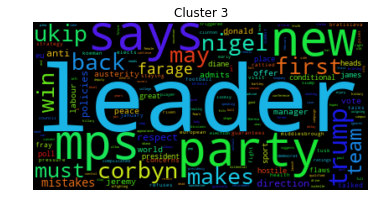

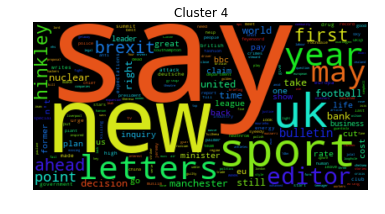

In [58]:
for i in range(0,5):
    lines = []
    for entry in df.iloc[[index for index, value in enumerate(models[4].labels_) if value == i]]['title_tokens']:
        lines.extend(entry[0])
    
    wc = WordCloud().generate(" ".join(lines))

    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Cluster {}'.format(i))
    plt.show()

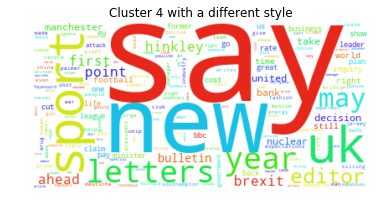

In [67]:
wc = WordCloud(background_color='white').generate(" ".join(lines))

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Cluster 4 with a different style')
plt.show()